<a href="https://colab.research.google.com/github/SarthakGarg13/OTOMYCOSIS/blob/master/Resnet_Otology_Git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from keras import regularizers
from keras.layers.core import Dropout
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

Using TensorFlow backend.


In [0]:
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
# NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
# STEPS_PER_EPOCH_TRAINING = 10
# STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 32
BATCH_SIZE_VALIDATION = 16

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [0]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [0]:
resnet_weights_path = '/content/drive/My Drive/ColabNotebooks/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = True, pooling = 'max', weights = 'imagenet')), Dropout(0.25),

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(6, activation = 'softmax',kernel_regularizer=regularizers.l2(0.01))), Dropout(0.1)

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = True


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
import keras
keras.__version__

'2.2.5'

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
from tensorflow.python.keras import optimizers

# sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE
# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/ColabNotebooks/TM imagesCNN',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/ColabNotebooks/TM imagesCNN',
        target_size=(image_size, image_size),
        batch_size=16,
        class_mode='categorical') 


Found 238 images belonging to 6 classes.
Found 238 images belonging to 6 classes.


In [0]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(32, 8, 16, 15)

In [0]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = './best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [0]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs = 15,
        validation_data=validation_generator,
        validation_steps=10,
        callbacks=[cb_checkpointer]
)
model.load_weights("./best.hdf5")

Epoch 1/15
10/10 [==============================] - 310s 31s/step - loss: 17.9206 - acc: 0.2947 - val_loss: 108.5551 - val_acc: 0.3688
Epoch 2/15
10/10 [==============================] - 282s 28s/step - loss: 7.3362 - acc: 0.4470 - val_loss: 37451.3982 - val_acc: 0.0625
Epoch 3/15
10/10 [==============================] - 268s 27s/step - loss: 4.4226 - acc: 0.5246 - val_loss: 11810.5823 - val_acc: 0.3688
Epoch 4/15
10/10 [==============================] - 295s 30s/step - loss: 13.6291 - acc: 0.3874 - val_loss: 28157.7234 - val_acc: 0.0938
Epoch 5/15
10/10 [==============================] - 284s 28s/step - loss: 8.2611 - acc: 0.3444 - val_loss: 2070.2381 - val_acc: 0.1250
Epoch 6/15
10/10 [==============================] - 267s 27s/step - loss: 5.5709 - acc: 0.3275 - val_loss: 9054.7856 - val_acc: 0.0625
Epoch 7/15
10/10 [==============================] - 279s 28s/step - loss: 2.0365 - acc: 0.5430 - val_loss: 2610.9000 - val_acc: 0.0625
Epoch 8/15
10/10 [==============================] -

In [0]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs = 15,
        validation_data=validation_generator,
        validation_steps=10,
        callbacks=[cb_checkpointer]
)
model.load_weights("./best.hdf5")

Epoch 1/15
10/10 [==============================] - 291s 29s/step - loss: 0.2320 - acc: 0.9636 - val_loss: 15.7265 - val_acc: 0.1312
Epoch 2/15
10/10 [==============================] - 284s 28s/step - loss: 0.2122 - acc: 0.9603 - val_loss: 17.4522 - val_acc: 0.0625
Epoch 3/15
10/10 [==============================] - 268s 27s/step - loss: 0.1357 - acc: 0.9930 - val_loss: 8.7722 - val_acc: 0.2500
Epoch 4/15
10/10 [==============================] - 290s 29s/step - loss: 0.1356 - acc: 0.9901 - val_loss: 2.6112 - val_acc: 0.4437
Epoch 5/15
10/10 [==============================] - 282s 28s/step - loss: 0.1232 - acc: 0.9934 - val_loss: 2.0237 - val_acc: 0.5437
Epoch 6/15
10/10 [==============================] - 284s 28s/step - loss: 0.1175 - acc: 1.0000 - val_loss: 1.1076 - val_acc: 0.7000
Epoch 7/15
10/10 [==============================] - 283s 28s/step - loss: 0.1163 - acc: 0.9967 - val_loss: 1.2678 - val_acc: 0.6687
Epoch 8/15
10/10 [==============================] - 275s 28s/step - loss: 

In [0]:
model.save('overfitting.h5')

In [0]:
weights_path = './best.hdf5'
def load_trained_model(weights_path):
   model = create_model()
   model.load_weights(weights_path)

In [0]:
test_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/ColabNotebooks/test',
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical')


Found 3 images belonging to 3 classes.


In [0]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


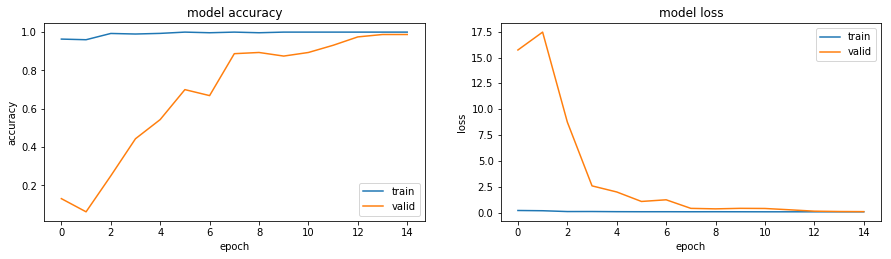

In [0]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [0]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

1/1 [==============================] - 3s 3s/step
